In [1]:
import os
import findspark

#os.environ["SPARK_HOME"] = "C:\spark"
#findspark.init()

# To display scroll:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .appName('Challenge 3')\
    .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/05 22:44:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.parquet('dataset_ml_parquet')

In [4]:
df.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|245000.0|           1|         0|     

# Transforming data

In [5]:
from pyspark.ml.feature import StringIndexer

In [6]:
# TODO: Try exploding into different columns
indexed = StringIndexer(inputCol='bairro', outputCol='bairro_ind').fit(df).transform(df)

In [7]:
indexed.show(5)

23/10/05 22:45:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-

In [8]:
from pyspark.ml.feature import VectorAssembler

In [84]:
X = [col for col in indexed.columns if col not in ['id', 'bairro']]
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'bairro_ind']

In [10]:
vectorized = VectorAssembler(inputCols=X, outputCol='features')\
    .transform(indexed)

In [11]:
vectorized.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+
|00002dd9-

# Scaling

In [12]:
from pyspark.ml.feature import StandardScaler

In [13]:
scaled = StandardScaler(inputCol='features', outputCol='scaled_features').fit(vectorized).transform(vectorized)

In [14]:
scaled.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+--------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|     scaled_features|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-

# PCA

In [15]:
from pyspark.ml.feature import PCA
import numpy as np

In [16]:
def calculate_pca(df, k, inputCol, outputCol):
    pca = PCA(k=k, inputCol=inputCol, outputCol=outputCol)
    model_pca = pca.fit(df)
    df_pca = model_pca.transform(df)
    print(model_pca.explainedVariance)
    acc_variance = np.array([sum(model_pca.explainedVariance[0:i+1]) for i in range(k)])
    print(acc_variance)
    return df_pca, acc_variance

In [17]:
k = 10

In [18]:
df_pca_indexed, acc_variance = calculate_pca(scaled, k, 'scaled_features', 'pca_features')

23/10/05 22:45:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/05 22:45:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/05 22:45:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/10/05 22:45:15 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
[0.25617113522577784,0.16924451836029555,0.08747806051799469,0.06243888206389001,0.05005883774979993,0.04467783455787977,0.04282209701045735,0.04006574190056978,0.033239795862782,0.028268304577343584]
[0.25617114 0.42541565 0.51289371 0.5753326  0.62539143 0.67006927
 0.71289137 0.75295711 0.7861969  0.81446521]


In [19]:
k = np.where(acc_variance >= 0.7)[0][0]+1
k

7

In [20]:
df_pca_indexed, acc_variance = calculate_pca(scaled, k, 'scaled_features', 'pca_features')

[0.2561711352257778,0.1692445183602958,0.08747806051799457,0.06243888206389001,0.05005883774979986,0.044677834557879686,0.04282209701045737]
[0.25617114 0.42541565 0.51289371 0.5753326  0.62539143 0.67006927
 0.71289137]


# Dummy variable

In [21]:
import pyspark.sql.functions as f

In [22]:
bairro = df\
    .groupBy('id')\
    .pivot('bairro')\
    .agg(f.lit(1))\
    .na.fill(0)
bairro.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

In [23]:
df_merged = bairro.join(df, 'id', how='left')
df_merged.show(5)

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+--------+-----------+------+--------+------------+-------+---------+---------------+------------+-----------------+-----------------+-------+--------+------------------------------+-----------------------+------+------+-------------+------+------+---------+---------+-----+------------+--------------+-------+-------+--------+-------+-----+---------+-----------+------+--------------+---------------+--------------+----------------+--------------+---+-----+-----------+------+----+-------------------+---------+----------------+---------+----------+--------+---------------+--------------+------+-----+------+------------+---------+-

In [24]:
X = [col for col in df_merged.columns if col not in ['id', 'bairro']]
print(X)
len(X)

['Abolição', 'Alto da Boa Vista', 'Anchieta', 'Andaraí', 'Anil', 'Bancários', 'Bangu', 'Barra da Tijuca', 'Barra de Guaratiba', 'Barros Filho', 'Benfica', 'Bento Ribeiro', 'Bonsucesso', 'Botafogo', 'Braz de Pina', 'Cachambi', 'Cacuia', 'Caju', 'Camorim', 'Campinho', 'Campo Grande', 'Campo dos Afonsos', 'Cascadura', 'Catete', 'Catumbi', 'Cavalcanti', 'Centro', 'Cidade Nova', 'Cidade de Deus', 'Cocotá', 'Coelho Neto', 'Colégio', 'Copacabana', 'Cordovil', 'Cosme Velho', 'Cosmos', 'Curicica', 'Del Castilho', 'Deodoro', 'Encantado', 'Engenheiro Leal', 'Engenho Novo', 'Engenho da Rainha', 'Engenho de Dentro', 'Estácio', 'Flamengo', 'Freguesia (Ilha do Governador)', 'Freguesia (Jacarepaguá)', 'Galeão', 'Gamboa', 'Gardênia Azul', 'Glória', 'Grajaú', 'Guadalupe', 'Guaratiba', 'Gávea', 'Higienópolis', 'Honório Gurgel', 'Humaitá', 'Inhaúma', 'Inhoaíba', 'Ipanema', 'Irajá', 'Itanhangá', 'Jacarepaguá', 'Jacaré', 'Jardim América', 'Jardim Botânico', 'Jardim Carioca', 'Jardim Guanabara', 'Jardim Sula

173

In [25]:
vectorized_dummy = VectorAssembler(inputCols=X, outputCol='features')\
    .transform(df_merged)
scaled_dummy = StandardScaler(inputCol='features', outputCol='scaled_features').fit(vectorized_dummy).transform(vectorized_dummy)
k = 173
df_pca_dummy, acc_variance = calculate_pca(scaled_dummy, k, 'scaled_features', 'pca_features')

[0.03761111270041066,0.02505465017300273,0.015936871434463488,0.012623940620265983,0.011217014079505528,0.008433828195566737,0.006996949482641588,0.006752460972939041,0.006348965384102638,0.006244271351715651,0.0061352361004930545,0.006047031184244012,0.005978387135771272,0.005973549839333749,0.005964198340410108,0.005929922226283077,0.00592379731651459,0.005900675791963088,0.005892102545382854,0.00588337266213748,0.005868168991476261,0.005854201388425569,0.005849057276579744,0.0058458026544006125,0.005842915382120797,0.00583582218410036,0.005830623845015404,0.005828425509696559,0.005827550760413321,0.0058250026166693095,0.005823383351422806,0.0058209619196291544,0.005818821623603262,0.005816966838660082,0.005811979950542116,0.005810929734963233,0.005809879498425504,0.005807078472207324,0.00580491209365269,0.005804452189516589,0.005801193489966357,0.005800727413790046,0.005800325377244486,0.005799316325997567,0.005797809432762474,0.0057973669502384695,0.005796844227692192,0.00579636429

In [26]:
k = np.where(acc_variance >= 0.7)[0][0]+1
k

107

# KMeans

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

## Indexed

In [30]:
def elbow_method(df, start, end):
    wcss = []
    for i in range(start,end):
        kmeans_model = KMeans(k=i, featuresCol='pca_features', predictionCol='prediction')
        predictions = kmeans_model.fit(df).transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        # Append WCSS to list
        wcss.append(silhouette)
    plt.plot(range(start,end), wcss)
    plt.xlabel('N clusters')
    plt.ylabel('WCSS')
    plt.show()

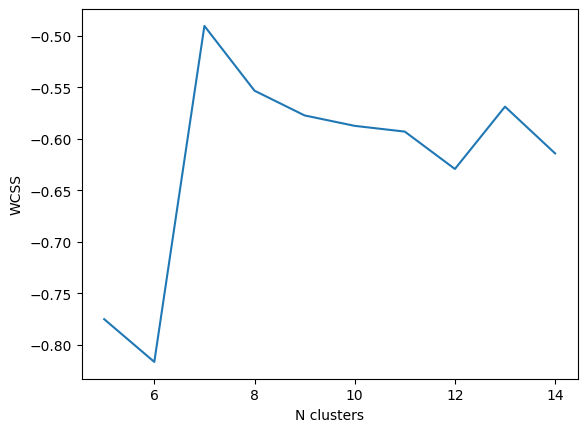

In [31]:
elbow_method(df_pca_dummy, 5, 15)

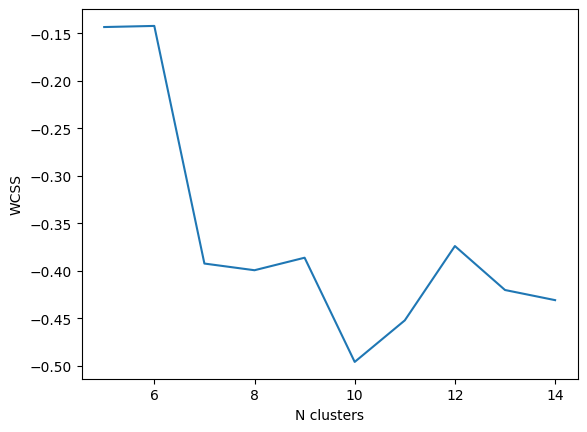

In [32]:
elbow_method(df_pca_indexed, 5, 15)

* Use df_pca_indexed with k = 7

In [67]:
kmeans_model = KMeans(k=9, featuresCol='pca_features', predictionCol='prediction')
predictions = kmeans_model.fit(df_pca_indexed).transform(df_pca_indexed)

In [68]:
predictions.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+--------------------+--------------------+----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|     scaled_features|        pca_features|prediction|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-

# Fiding similar

In [69]:
def find_similar(df, item_id):
    cluster = df.filter(predictions.id == item_id).select('prediction').collect()[0][0]
    print(cluster)
    return df.filter(predictions.prediction == cluster)

In [70]:
item_id = predictions.take(1)[0]['id']

In [71]:
similar = find_similar(predictions, item_id)

3


In [72]:
similar.show(5)

+--------------------+-----+---------+---------+-------+------+----+-----------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+--------------------+--------------------+----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|           bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|     scaled_features|        pca_features|prediction|
+--------------------+-----+---------+---------+-------+------+----+-----------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----

In [73]:
similar.select('bairro').show(15)

+-----------------+
|           bairro|
+-----------------+
|     Santo Cristo|
|         Cachambi|
|Praça da Bandeira|
|            Méier|
|           Grajaú|
|       Água Santa|
|     Santo Cristo|
|         Maracanã|
|         Maracanã|
|  Todos os Santos|
|      Vila Isabel|
|      Vila Isabel|
|         Cachambi|
|  Todos os Santos|
|         Cachambi|
+-----------------+
only showing top 15 rows



In [74]:
find_similar(predictions, predictions.take(3)[-1]['id']).select('bairro').show(15)

0
+------------+
|      bairro|
+------------+
|Santa Teresa|
|  Copacabana|
|    Botafogo|
|  Copacabana|
|      Leblon|
|  Copacabana|
|  Copacabana|
|  Copacabana|
|    Botafogo|
|     Ipanema|
|    Botafogo|
|    Botafogo|
| Laranjeiras|
|        Leme|
| Laranjeiras|
+------------+
only showing top 15 rows



# Euclidian distance

In [75]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [76]:
components = predictions.filter(predictions.id == item_id)\
    .select("pca_features").collect()[0][0]
components

DenseVector([-5.9578, 1.8636, -1.6782, 1.3222, -0.1491, -0.3092, -6.3923])

In [161]:
def euclidian_distance(value):
    return euclidean(components, value)

udf_euclidian_distance = f.udf(euclidian_distance, FloatType())

In [162]:
recommended = predictions.withColumn('Dist', udf_euclidian_distance('pca_features'))
                               
recommended_10 = spark.createDataFrame(recommended.sort('Dist').take(50))\
    .select(['bairro','id','Dist'])

recommended_10.show()

+------------+--------------------+--------------------+
|      bairro|                  id|                Dist|
+------------+--------------------+--------------------+
|Santo Cristo|00002dd9-cc74-480...|1.149408395068399...|
|Santo Cristo|d187d98b-2291-486...|  0.0722355842590332|
|Santo Cristo|1238503b-dbbc-466...| 0.07299035042524338|
|Santo Cristo|3fe19ed1-3b37-4ac...| 0.07362913340330124|
|Santo Cristo|63b14166-0cd2-40f...| 0.07365346699953079|
|Santo Cristo|562af84b-6b6d-422...|  0.0736599788069725|
|Santo Cristo|6509131b-e29b-453...| 0.07378256320953369|
|Santo Cristo|ed0abaaa-696d-4ca...|  0.0775553360581398|
|Santo Cristo|f2eef5f7-a2cc-437...| 0.08346345275640488|
|Santo Cristo|770c3a65-48e3-477...| 0.08796977996826172|
|Santo Cristo|de52ec69-c928-45f...|  0.1456371247768402|
|Santo Cristo|c242a1a5-e85d-477...|  0.1457023024559021|
|Santo Cristo|d09bd1f5-a9a3-4cb...|  0.1472882330417633|
|Santo Cristo|1e6db0e9-b8fe-4a0...| 0.20086818933486938|
|Santo Cristo|7e45a4f9-20da-4a1

# Pipeline

In [85]:
X = [col for col in indexed.columns if col not in ['id', 'bairro']]
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas',
 'bairro_ind']

In [80]:
from pyspark.ml import Pipeline

In [86]:
indexer_pipeline = Pipeline(stages=[
    StringIndexer(inputCol='bairro', outputCol='bairro_ind'),
    VectorAssembler(inputCols=X, outputCol='features'),
    StandardScaler(inputCol='features', outputCol='scaled_features'),
    PCA(k=7, inputCol='scaled_features', outputCol='pca_features'),
    KMeans(k=7, featuresCol='pca_features', predictionCol='prediction')
])

In [87]:
predictions = indexer_pipeline.fit(df).transform(df)

# Recommender function

In [115]:
predictions.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------+--------------------+--------------------+----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|bairro_ind|            features|     scaled_features|        pca_features|prediction|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-

In [173]:
def recommender(id, top_n=10):
    cluster = predictions.filter(predictions.id == id).select('prediction').collect()[0][0]
    recommended = predictions.filter(predictions.prediction == cluster)
    components = recommended.filter(predictions.id == id)\
        .select("pca_features").collect()[0][0]
    recommended = recommended.withColumn('Dist', udf_euclidian_distance('pca_features'))
    top_df = spark.createDataFrame(recommended.sort('Dist').take(top_n))\
        .select(['bairro',
                 'andar',
                 'area_util',
                 'banheiros',
                 'quartos',
                 'suites',
                 'vaga',
                 'condominio',
                 'iptu',
                 'valor',
                 'Zona Central',
                 'Zona Norte',
                 'Zona Oeste',
                 'Zona Sul',
                 'Academia',
                 'Animais permitidos',
                 'Churrasqueira',
                 'Condomínio fechado',
                 'Elevador',
                 'Piscina',
                 'Playground',
                 'Portaria 24h',
                 'Portão eletrônico',
                 'Salão de festas',
                 'id',
                 'Dist',
                 'prediction'])
    return top_df

In [174]:
predictions.show(10, truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+---------------+----------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+----------+--------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|id                      

In [175]:
item_id = '0009ca94-2b37-4381-b8b8-773ce0f92444'

In [176]:
top_df = recommender(item_id, 20)
top_df.show()

+------------+-----+---------+---------+-------+------+----+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+------------------+----------+
|      bairro|andar|area_util|banheiros|quartos|suites|vaga|condominio| iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|                  id|              Dist|prediction|
+------------+-----+---------+---------+-------+------+----+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+------------------+----------+
|     Estácio|    3|       69|        2|      